In [6]:
install.packages("ISLR2")


The downloaded binary packages are in
	/var/folders/k0/5jhn7d7s1l75cf1srqv1wy980000gn/T//RtmpSnAy7O/downloaded_packages


In [7]:
library(ISLR2)
library(randomForest)
library(ggplot2)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'ggplot2'


The following object is masked from 'package:randomForest':

    margin




## Random Forests
### Fitting Forests
Here we fit a regression tree to the  `Boston`  data set.

### The Boston Data

A data set containing housing values in 506 suburbs of Boston.
     
- `crim`: per capita crime rate by town.

- `zn`: proportion of residential land zoned for lots over 25,000
sq.ft.

- `indus`: proportion of non-retail business acres per town.

- `chas`: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).

- `nox`: nitrogen oxides concentration (parts per 10 million).

- `rm`: average number of rooms per dwelling.

- `age`: proportion of owner-occupied units built prior to 1940.

- `dis`: weighted mean of distances to five Boston employment centres.

- `rad`: index of accessibility to radial highways.

- `tax`: full-value property-tax rate per $10,000.

- `ptratio`: pupil-teacher ratio by town.

- `lstat`: lower status of the population (percent).

- `medv`: median value of owner-occupied homes in $1000s.

This dataset was obtained from, and is slightly modified from, the
Boston dataset that is part of the `R` library `MASS`.  References are
available in the MASS library.

The steps for regression trees are similar to those for classification trees.

In [12]:
data(Boston)

First, we split the data into training and test sets, and fit the tree
to the training data. Here we use 30% of the data for the test set.


In [9]:
set.seed(1)
# divimos en 1/3 para el test, y 2/3 para el trainning
train <- sample(1:nrow(Boston), nrow(Boston) / 2)

## Bagging and Random Forests
Here we apply bagging and random forests to the `Boston` data, using
the `randomForest` function from the `randomForest` package. Recall
that bagging is simply a special case of a random forest with
$m=p$. Therefore, the `randomForest`  function can be used to
perform both bagging and random forests. We start with bagging.

In [10]:
# decimos que meta todas las variables (12) 
rf_boston <- randomForest(formula = medv ~ ., data = Boston,
                          mtry = 12,
                          importance = TRUE, subset = train)
rf_boston


Call:
 randomForest(formula = medv ~ ., data = Boston, mtry = 12, importance = TRUE,      subset = train) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 12

          Mean of squared residuals: 11.25779
                    % Var explained: 85.35

The argument `mtry` indicates that all 12 predictors should
be considered for each split of the tree --- in other words, that
bagging should be done.  How well does this bagged model perform on
the test set?

In [14]:
boston_test <- Boston[-train, ]
yhat.rf <- predict(rf_boston, newdata = boston_test)
mean((yhat.rf - boston_test$medv)^2)

[1] 23.40359

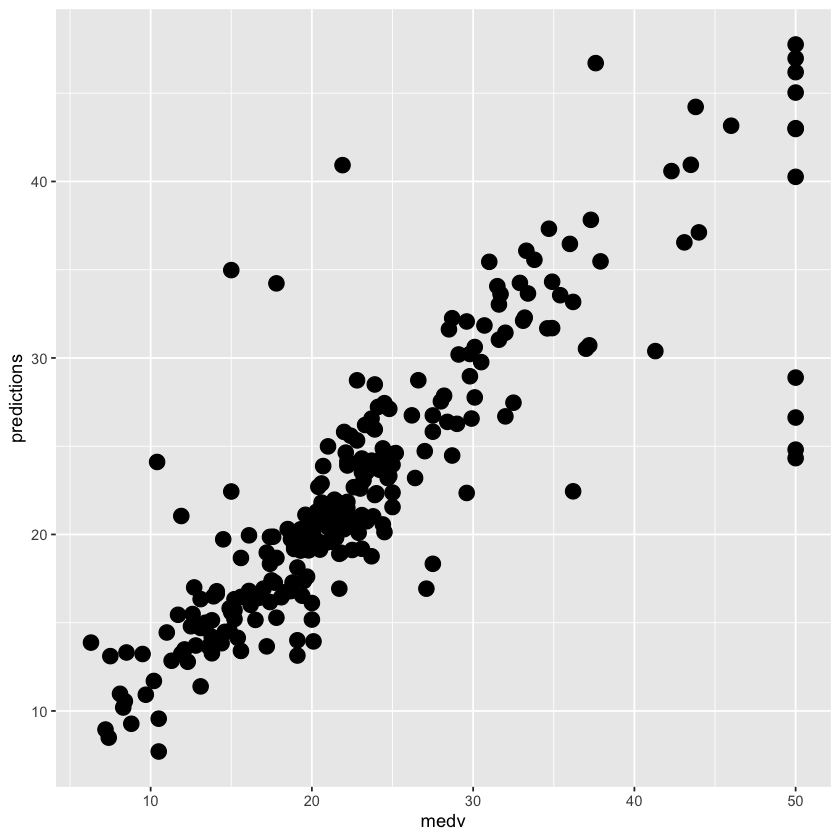

In [15]:
boston_test$predictions <- yhat.rf

plot <- ggplot(boston_test, aes(medv, predictions))
plot + geom_point(size = 4)

The test set MSE associated with the bagged regression tree is
23.4. 

Growing a random forest proceeds in exactly the same way, except that
we use a smaller value of the `mtry` argument. By default,
`randomForest`  uses $p / 3$ variables when building a random
forest of regression trees (i.e. it defaults to bagging), and 
$\sqrt{p}$ variables when building a
random forest of classification trees. Here we use `mtry=6`.

In [16]:
rf_boston <- randomForest(formula = medv ~ ., data = Boston,
                          importance = TRUE, subset = train,
                          mtry = 6)
yhat.srf <- predict(rf_boston, newdata = Boston[-train, ])
mean((yhat.srf - boston_test$medv)^2)

[1] 19.5178

In [17]:
importance(rf_boston)

,%IncMSE,IncNodePurity
crim,15.4241320,1137.83607
zn,3.6465923,100.11749
indus,5.7768966,570.48176
chas,-0.4358076,29.83094
nox,12.0786127,705.40195
rm,34.1438887,8069.21252
age,14.0265168,629.61352
dis,8.0595748,669.82707
rad,3.6622932,103.04074
tax,8.7167625,307.47855


 This
is a relative measure of the total decrease in node impurity that results from
splits over that variable, averaged over all trees

The results indicate that across all of the trees considered in the
random forest, the wealth level of the community (`lstat`) and the
house size (`rm`) are by far the two most important variables.



## Causal Forest

In [18]:
url <- "https://raw.githubusercontent.com/d2cml-ai/CausalAI-Course/refs/heads/main/Labs/PD/PD10/online_discounts.csv"
df <- read.csv(url)
head(df)

,X,time,device,browser,region,discount,spend
,<int>,<dbl>,<chr>,<chr>,<int>,<int>,<dbl>
1,0,10.7790063,mobile,edge,9,0,0.4551642
2,1,0.5689725,desktop,firefox,9,0,11.0368706
3,2,3.7438714,mobile,safari,7,0,1.8111930
4,3,13.3734357,desktop,other,5,0,31.9049439
5,4,0.7085752,mobile,explorer,2,1,15.4198624
6,5,10.8320878,desktop,brave,0,0,24.1239264


We have data on 100.000 store visitors, for whom we observe the `time` of the day the acessed the website, the `device` they use, their `browser`, and their geographical `region`. We also see whether they were offered the `discount`, our treatment, and what is their `spend`, the outcome of interest. The following code snippet describes how this effect (the value of $Y_i(1)-Y_i(0)$ for each user $i$) is generated (in Python).

```python
effect = 7*np.exp(-(df.time-18)**2/100) + 3*(df.browser=='safari') - 2*(df.device=='desktop') + (df.region=='3') - 2.5
```

Since the treatment was randomly assigned, we can use a simple **difference-in-means** estimator to estimate the treatment effect. We expect the treatment and control group to be similar, except for the `discount`, therefore we can causally attribute any difference in `spend` to the `discount`.

In [19]:
model <- lm(spend ~ discount, data = df)

summary(model)$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),5.122072,0.04543493,112.73424,0.000000e+00
discount,1.750692,0.06421938,27.26111,4.866824e-163


The discount seems to be effective: on average the spend in the treatment group increases by 1.95$. But are all customers equally affected?

To answer this question, we would like to estimate **heterogeneous treatment effects**, possibly at the individual level. 
There are many different options to compute heterogeneous treatment effects. The simplest one is to interact the outcome of interest with a dimension of heterogeneity. The problem with this approach is which variable to pick. Sometimes we have prior information that might guide out actions; for example, we might know that `mobile` users on average spend more than `desktop` users. Other times, we might be interested in one dimension for business reasons; for example we might want to invest more in a certain `region`. However, when we do not extra information we would like this process to be data-driven.

In the previous Lab we have explored one data-driven approach to estimate heterogeneous treatment effects: **causal trees**. We will now expand them to causal forests.
Causal Forests are the equivalent of random forests, but for the estimation of heterogeneous treatment effects, exaxtly as for causal trees and regression trees. Exactly as for Causal Trees, we have a fundamental problem: we are interested in predicting an object that we do not observe: the individua treatment effects $\tau_i$. The solution is to create an auxiliary outcome variable $Y^*$ whose expected value for each single observation is exactly the treatment effect.

$$
Y_i^* = \frac{Y_i}{D_i \cdot p(X_i) - (1-D_i) \cdot (1-p(X_i))}
$$

Once we have an outcome variable, there are still a couple of things we need to do in order to use Random Forests to estimate heterogeneous treatment effects. First, we need to build trees that have an equal number of treated and control units in each leaf. Second, we need to use different samples to build the tree and evaluate it, i.e. compute the average outcome per leaf. This procedure is often referred to as **honest trees** and it's extremely helpful for inference, since we can treat the sample of each leaf as independent from the tree structure. 

Before we go into the estimation, let's first generate dummy variables for our categorical variables, `device`, `browser` and `region`.

In [20]:
library(grf)
library(fastDummies)

X <- df[, c("time", "device", "browser", "region")]
X <- dummy_cols(X, remove_first_dummy = TRUE, remove_selected_columns = TRUE)
Y <- df[, "spend"]
W <- df[, "discount"]
cf <- causal_forest(X, Y, W)

Differently from Causal Trees, Causal Forests are harder to interpret since we cannot visualize every single tree. We can use the `get_tree` function to inspect an equivalent representation of the Causal Forest algorithm.

In [21]:
cf_smalltrees <- causal_forest(X, Y, W, min.node.size = 3000)
tree <- get_tree(cf_smalltrees, 1)
tree

GRF tree object 
Number of training samples: 50000 
Variable splits: 
(1) split_variable: time  split_value: 11.9577 
  (2) split_variable: time  split_value: 5.91283 
    (4) * num_samples: 6116  avg_Y: 5.15 avg_W: 0.51 
    (5) * num_samples: 6282  avg_Y: 5.47 avg_W: 0.51 
  (3) split_variable: device_mobile  split_value: 0 
    (6) * num_samples: 6300  avg_Y: 6.04 avg_W: 0.51 
    (7) * num_samples: 6302  avg_Y: 7 avg_W: 0.5 

We can interpret the tree diagram exactly as for the Causal Tree model.

The problem with this representation is that, differently from the case of Causal Trees, it is only an interpretation of the model. Since Causal Forests are made of many bootstrapped trees, there is no way to directly inspect each decision tree. One way to understand which feature is most important in detemining the tree split is the so-called [feature importance](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html).

In [22]:
varimp <- variable_importance(cf)
ranked.vars <- order(varimp, decreasing = TRUE)
importances <- data.frame(variable = colnames(X)[ranked.vars], importance = varimp[ranked.vars])
importances

variable,importance
<chr>,<dbl>
time,0.730263398
browser_safari,0.132305383
device_mobile,0.083759321
region,0.024490913
browser_edge,0.009399045
browser_other,0.008420231
browser_chrome,0.004158779
browser_explorer,0.003623005
browser_firefox,0.003579925


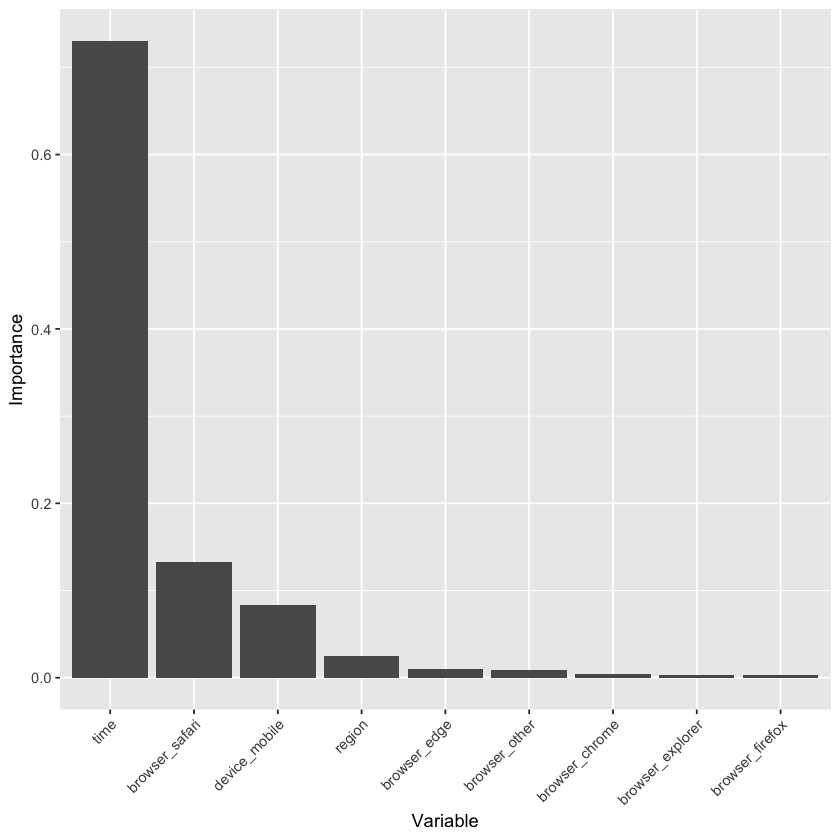

In [23]:
library(forcats)
figure <- ggplot(importances,
                 aes(fct_rev(fct_reorder(variable, importance)), importance))
figure + geom_col() +
  scale_x_discrete(guide = guide_axis(angle = 45)) +
  labs(x = "Variable", y = "Importance")

Clearly `time` is the first dimension of heterogeneity, followed by `device` (mobile in particular) and `browser` (safari in particular). Other dimensions do not matter much.

We can now do a more relevant test: how well the algorithm performs with a continuous variable such as `time`? First, let’s again isolate the predicted treatment effects on `time` and ignore the other covariates.

In [ ]:
df$effects <- 7 * exp(-(df$time - 18) ^ 2 / 100) +
  3 * (df$browser == "safari") -
  2 * (df$device == "desktop") +
  (df$region == "3") - 2.5

df$effects[df$effects < 0] = 0

In [33]:
df$predicted_effects <- predict(cf, X)$predictions

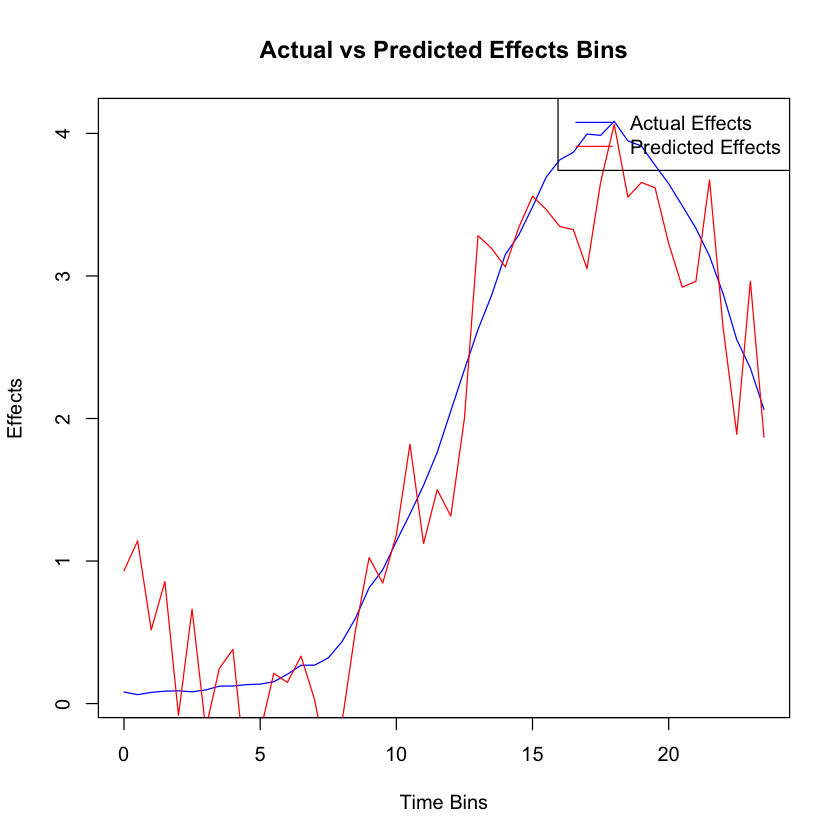

In [36]:
# Assuming df is your data frame and X contains predictor column names

# Create time_bins by rounding time to the nearest 0.5
df$time_bins <- floor(df$time * 2) / 2

# Calculate the mean effects for each time bin
effects_bins <- aggregate(effects ~ time_bins, data = df, mean)

# Generate predictions using the model (assuming forest_model is trained)
df$predicted_effects <- predict(cf, X)$predictions

# Calculate the mean predicted effects for each time bin
predicted_effects_bins <- aggregate(predicted_effects ~ time_bins, data = df, mean)

# Plot the actual vs. predicted effects bins
plot(effects_bins$time_bins, effects_bins$effects, type = "l", col = "blue",
     xlab = "Time Bins", ylab = "Effects", main = "Actual vs Predicted Effects Bins")
lines(predicted_effects_bins$time_bins, predicted_effects_bins$predicted_effects, col = "red")
legend("topright", legend = c("Actual Effects", "Predicted Effects"), col = c("blue", "red"), lty = 1)